In [58]:
import warnings

import numpy as np
import pandas as pd

from jre_utils.datapath import (
    factor_data_paths,
    model_ready_data_paths,
    get_price_index_path
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [122]:
dataset_asset_type = "combined"
dataset_key = "transactions"
years_ahead = 4

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "robust"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
metric_sharpe = metric + "_sharpe"

get_data_path = get_price_index_path


In [123]:
population_path = factor_data_paths["processed"]["population"]["municipality"]
migration_path = factor_data_paths["processed"]["migration"]["municipality"]
taxable_income_path = factor_data_paths["processed"]["taxable_income"]["municipality"]
new_dwellings_path = factor_data_paths["processed"]["new_dwellings"]["municipality"]
lfs_revenue_path = factor_data_paths["processed"]["lfs_revenue_breakdown"]["municipality"]

dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

In [124]:
# concat all asset types horizontally here
# Once creating time series dataset,
# create 3 datasets and concat them vertically
# To do that, loop 3 times with different metrics

In [125]:
id_columns = ["area_code", "area", "year"]

factor_log_normalize_columns = [
    "in_migrations",
    "out_migrations",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",

    # Log normalizing seems to be good for everything!
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = [
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
)

final_factor_columns = list(set(factor_normalize_columns + factor_log_normalize_columns + factor_columns))

In [126]:
core_log_normalize_columns = ["yearly_price_growth"]
core_normalize_columns = ["yearly_price_growth"]
core_maintain_columns = ["weight", "count", "metric_pct_chg_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

final_core_columns = list(set(core_normalize_columns + core_log_normalize_columns + core_columns))

combined_final_core_columns = [f"{asset_type}_{column}" for column in final_core_columns for asset_type in asset_types]

In [127]:
# combined_final_core_columns

In [128]:
final_columns = id_columns + combined_final_core_columns + final_factor_columns

In [129]:
df = pd.read_csv(get_data_path("building"))
df = df.sort_values(by=group_by_columns, ascending=True)
df = df[group_by_columns + [metric]]

# prepare additional factors
df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
df["log_yearly_price_growth"] = np.log(1 + df["yearly_price_growth"])

# prepare main metrics
df[metric_pct_chg] = df.groupby(granularity_columns)[metric].pct_change(
    periods=years_ahead
)

df[metric_sharpe] = df.groupby(granularity_columns)[
    "log_yearly_price_growth"
].transform(lambda x: x.rolling(years_ahead).mean() / x.rolling(years_ahead).std())

<Axes: xlabel='robust_price_index_pct_chg', ylabel='robust_price_index_sharpe'>

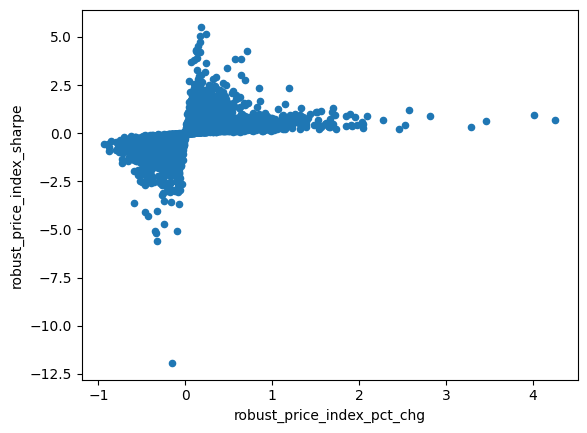

In [130]:
df.plot.scatter(x=metric_pct_chg, y=metric_sharpe)

In [93]:
derived_dfs = {}

for asset_type in asset_types:
    df =  pd.read_csv(get_data_path(asset_type))
    df = df.sort_values(by=group_by_columns, ascending=True)
    df = df[group_by_columns + [metric, "count", "robust_weights"]]

    # prepare main metric
    df[metric_pct_chg] = df.groupby(granularity_columns)[metric].pct_change(periods=years_ahead)

    # Create weight for metric
    df["shifted_weights"] = df.groupby(granularity_columns)["robust_weights"].shift(years_ahead)
    df["shifted_weights"] = df["shifted_weights"].fillna(1)
    df["weight"] = np.sqrt(df["robust_weights"] * df["shifted_weights"])

    # prepare additional factors
    df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
    df["metric_pct_chg_is_available"] = df[metric_pct_chg].notnull().astype(int)

    for column in core_log_normalize_columns:
        df[f"{column}_log"] = df[column].apply(lambda x: np.log10(1 + x))
        df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
            lambda x: (x - x.mean()) / x.std()
        )

    for column in core_normalize_columns:
        df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
            lambda x: (x - x.mean()) / x.std()
        )

    df = df[group_by_columns + final_core_columns]
    
    derived_dfs[asset_type] = df.rename(
        columns={column: f"{asset_type}_{column}" for column in final_core_columns}
    )

combined_derived_dfs = (
    derived_dfs["building"].merge(
        derived_dfs["land"],
        on=["year", "area_code", "area"],
        how="outer",
    ).merge(
        derived_dfs["condo"],
        on=["year", "area_code", "area"],
        how="outer",
    )
)

<Axes: ylabel='Frequency'>

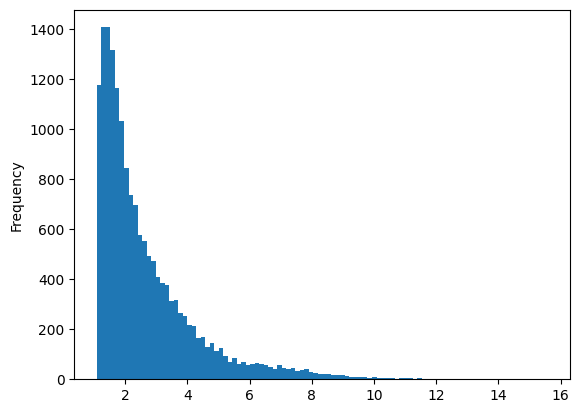

In [33]:
derived_dfs["building"]["building_weight"].plot.hist(bins=100)

In [34]:
df = combined_derived_dfs

population_df = pd.read_csv(population_path)
migration_df = pd.read_csv(migration_path)
taxable_income_df = pd.read_csv(taxable_income_path)
new_dwellings_df = pd.read_csv(new_dwellings_path)
lfs_revenue_df= pd.read_csv(lfs_revenue_path)

df = (
    df.merge(population_df, on=group_by_columns, how="left")
    .merge(migration_df, on=group_by_columns, how="left")
    .merge(taxable_income_df, on=group_by_columns, how="left")
    .merge(new_dwellings_df, on=group_by_columns, how="left")
    .merge(lfs_revenue_df, on=group_by_columns, how="left")
)

In [35]:
df["migrations_is_available"] = df["net_migration_ratio"].notnull().astype(int)
df["taxable_income_is_available"] = df["taxable_income"].notnull().astype(int)
df["total_tax_is_available"] = df["total_tax"].notnull().astype(int)
df["dwellings_is_available"] = df["new_dwellings"].notnull().astype(int)

In [36]:
df = df[final_columns]

In [37]:
df.to_csv(model_ready_data_path, index=False)

In [38]:
df.describe()

,area_code,year,land_robust_price_index_pct_chg_normalized_yearly,building_robust_price_index_pct_chg_normalized_yearly,condo_robust_price_index_pct_chg_normalized_yearly,land_weight,building_weight,condo_weight,land_metric_pct_chg_is_available,building_metric_pct_chg_is_available,condo_metric_pct_chg_is_available,land_yearly_price_growth_log_normalized_yearly,building_yearly_price_growth_log_normalized_yearly,condo_yearly_price_growth_log_normalized_yearly,land_count,building_count,condo_count,land_yearly_price_growth,building_yearly_price_growth,condo_yearly_price_growth,land_robust_price_index_pct_chg_log_normalized_yearly,building_robust_price_index_pct_chg_log_normalized_yearly,condo_robust_price_index_pct_chg_log_normalized_yearly,land_yearly_price_growth_normalized_yearly,building_yearly_price_growth_normalized_yearly,condo_yearly_price_growth_normalized_yearly,land_robust_price_index,building_robust_price_index,condo_robust_price_index,land_robust_price_index_log_normalized_yearly,building_robust_price_index_log_normalized_yearly,condo_robust_price_index_log_normalized_yearly,land_robust_price_index_pct_chg,building_robust_price_index_pct_chg,condo_robust_price_index_pct_chg,existing_dwellings_log_normalized_yearly,taxable_income_log_normalized_yearly,total_tax_growth_log_normalized_yearly,total_tax_growth,taxable_income_growth_normalized_yearly,total_tax_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_per_taxpayer_growth,out_migrations,new_dwellings_ratio,taxable_income_is_available,taxable_income_growth,out_migrations_log_normalized_yearly,new_dwellings_ratio_log_normalized_yearly,new_dwellings_ratio_normalized_yearly,total_tax_growth_normalized_yearly,new_dwellings,total_tax,taxable_income,taxable_income_per_taxpayer_growth_log_normalized_yearly,taxpayer_count_growth,dwellings_is_available,total_tax_is_available,migrations_is_available,net_migration_ratio_normalized_yearly,taxable_income_growth_log_normalized_yearly,taxpayer_count_growth_normalized_yearly,population_log_normalized_yearly,in_migrations_log_normalized_yearly,new_dwellings_log_normalized_yearly,net_migration_ratio,existing_dwellings,in_migrations,population,taxable_income_per_taxpayer_log_normalized_yearly,net_migration_ratio_log_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,taxpayer_count,taxable_income_per_taxpayer,taxpayer_count_growth_log_normalized_yearly
count,19269.000000,19269.000000,1.748400e+04,1.576900e+04,4.423000e+03,18709.000000,16880.000000,4733.000000,18709.000000,16880.000000,4733.000000,1.748400e+04,1.576900e+04,4.423000e+03,18709.000000,16880.000000,4733.000000,17484.000000,15769.000000,4423.000000,1.748400e+04,1.576900e+04,4.423000e+03,1.748400e+04,1.576900e+04,4.423000e+03,18709.000000,16880.000000,4733.000000,18709.000000,16880.000000,4733.000000,17484.000000,15769.000000,4423.000000,11580.000000,18011.000000,19189.000000,19189.000000,18011.000000,19207.000000,18011.000000,18011.000000,19269.000000,11580.000000,19269.000000,18011.000000,19269.000000,11580.000000,11580.000000,19189.000000,11580.000000,1.920700e+04,1.801100e+04,18011.000000,18011.000000,19269.000000,19269.000000,19269.0,19269.000000,18011.000000,18011.000000,19269.000000,19269.000000,11580.000000,19269.000000,1.158000e+04,19269.000000,1.926900e+04,18011.000000,19269.000000,18011.000000,1.801100e+04,18011.000000,18011.000000
mean,21813.182781,2014.824589,-9.753504e-18,2.027676e-18,6.275283e-18,3.181848,2.694432,4.094884,0.934523,0.934182,0.934502,2.438376e-18,-2.647244e-18,-2.971974e-17,87.853279,102.828614,164.578703,-0.000733,0.014267,0.032597,2.438376e-18,-2.647244e-18,-2.971974e-17,-9.753504e-18,2.027676e-18,6.275283e-18,80.687004,89.752148,117.185139,0.004356,0.004295,-0.007500,-0.000733,0.014267,0.032597,-0.092673,0.460514,0.040685,0.004762,0.035069,0.594129,0.464750,0.001418,4129.135249,0.013460,0.934714,0.003182,0.307891,-0.078837,-0.078702,0.038539,1106.602159,1.569833e+07,1.546329e+08,-0.014773,0.001648,0.6

In [39]:
area_code = 1100
df[df["area_code"] == area_code][["year"] + [f"{asset_type}_yearly_price_growth" for asset_type in asset_types] + [f"{asset_type}_weight" for asset_type in asset_types]]

,year,land_yearly_price_growth,building_yearly_price_growth,condo_yearly_price_growth,land_weight,building_weight,condo_weight
5110,2006,NaN,NaN,NaN,1.759977,1.100524,NaN
5111,2007,-0.023603,-0.028062,NaN,3.176035,1.205563,2.294608
5112,2008,-0.053746,-0.009394,-0.027502,3.435090,1.200000,6.093365
5113,2009,-0.113495,-0.053373,-0.030010,4.003999,1.397969,8.062652
5114,2010,0.034940,0.005433,0.019878,4.309160,1.604029,8.570418
5115,2011,-0.010958,-0.002184,0.036768,4.233697,1.589695,6.631317
5116,2012,-0.001519,-0.003489,0.059215,4.276582,1.615363,3.095676
5117,2013,0.034730,0.019415,0.062151,4.166829,1.541773,2.712277
5118,2014,-0.074144,-0.018326,0.070749,4.302079,1.538427,5.794973
5119,2015,-0.020721,0.015165,0.067969,4.633866,1.554466,9.406750


In [42]:
# loop

for years_ahead in range(1, 5):
    dataset_name = f"sequence_{dataset_key}_{dataset_asset_type}_{metric_key}_{years_ahead}"
    model_ready_data_path = model_ready_data_paths[dataset_name]
    
    derived_dfs = {}

    for asset_type in asset_types:
        df =  pd.read_csv(get_data_path(asset_type))
        df = df.sort_values(by=group_by_columns, ascending=True)
        df = df[group_by_columns + [metric, "count", "robust_weights"]]

        # prepare main metric
        df[metric_pct_chg] = df.groupby(granularity_columns)[metric].pct_change(periods=years_ahead)

        # Create weight for metric
        df["shifted_weights"] = df.groupby(granularity_columns)["robust_weights"].shift(years_ahead)
        df["shifted_weights"] = df["shifted_weights"].fillna(1)
        df["weight"] = np.sqrt(df["robust_weights"] * df["shifted_weights"])

        # prepare additional factors
        df["yearly_price_growth"] = df.groupby(granularity_columns)[metric].pct_change()
        df["metric_pct_chg_is_available"] = df[metric_pct_chg].notnull().astype(int)

        for column in core_log_normalize_columns:
            df[f"{column}_log"] = df[column].apply(lambda x: np.log10(1 + x))
            df[f"{column}_log_normalized_yearly"] = df.groupby("year")[f"{column}_log"].transform(
                lambda x: (x - x.mean()) / x.std()
            )

        for column in core_normalize_columns:
            df[f"{column}_normalized_yearly"] = df.groupby("year")[column].transform(
                lambda x: (x - x.mean()) / x.std()
            )

        df = df[group_by_columns + final_core_columns]
        
        derived_dfs[asset_type] = df.rename(
            columns={column: f"{asset_type}_{column}" for column in final_core_columns}
        )

    df = (
        derived_dfs["building"].merge(
            derived_dfs["land"],
            on=["year", "area_code", "area"],
            how="outer",
        ).merge(
            derived_dfs["condo"],
            on=["year", "area_code", "area"],
            how="outer",
        )
    )

    population_df = pd.read_csv(population_path)
    migration_df = pd.read_csv(migration_path)
    taxable_income_df = pd.read_csv(taxable_income_path)
    new_dwellings_df = pd.read_csv(new_dwellings_path)
    lfs_revenue_df= pd.read_csv(lfs_revenue_path)

    df = (
        df.merge(population_df, on=group_by_columns, how="left")
        .merge(migration_df, on=group_by_columns, how="left")
        .merge(taxable_income_df, on=group_by_columns, how="left")
        .merge(new_dwellings_df, on=group_by_columns, how="left")
        .merge(lfs_revenue_df, on=group_by_columns, how="left")
    )

    df["migrations_is_available"] = df["net_migration_ratio"].notnull().astype(int)
    df["taxable_income_is_available"] = df["taxable_income"].notnull().astype(int)
    df["total_tax_is_available"] = df["total_tax"].notnull().astype(int)
    df["dwellings_is_available"] = df["new_dwellings"].notnull().astype(int)

    df.to_csv(model_ready_data_path, index=False)
